# Throughput Analysis

This notebook describes the steps to do an analysis of throughput data. This supports the capability analysis of flow systems, like a kanban system.

This notebook is compatible with the section 'Understanding leadtime' from the [Kanban Maturity Model](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiIi9Py19zwAhW2DWMBHdKYDz0QFjALegQIHRAD&url=https%3A%2F%2Fmauvisoft.com%2Fkmm-understanding-lead-time%2F&usg=AOvVaw1iDIcri4tDi3vxo1W6yJp-)

## Table of contents

* [Throughput data](#Throughput-data)
* [Basic properties](#Basic-properties-of-the-data-set)
* [Visualisation of the data](#Visualisation-of-the-data)
  * [Thin- or fat-tailed data?](#Thin--or-fat-tailed-data?)
* [Empirical distribution](#Empirical-distribution)
* [References](#References)

## Set-up

In [14]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Distribution.Utilities, as: DU
alias Chi2fit.Statistics, as: S
alias Chi2fit.Utilities, as: U
alias Chi2fit.Gnuplotlib, as: P

Chi2fit.Gnuplotlib

## Throughput data

First, decide on an interval for which to capture the throughput. Depending on the context and amount of data, daily, weekly, bi-weekly, or monthly intervals are common choices.

In [15]:
# Specify the interval in a number of days:
interval = 7

7

Next, choose the workitem to use for the throughput. For each interval count the number of work items completed in that interval. Partially completed items are excluded from the count.

In [16]:
# The raw throughput data:
raw = [1, 2, 0, 3, 0, 3, 1, 6, 0, 0, 1, 1, 0, 0, 1, 0, 3, 4, 5, 1, 7, 2, 3, 2, 1, 0, 1, 2, 0, 1, 0, 6, 5, 6, 0, 5, 0, 0, 2, 0, 0, 0, 1, 2, 15, 3, 1, 5, 2, 4, 0]

[1, 2, 0, 3, 0, 3, 1, 6, 0, 0, 1, 1, 0, 0, 1, 0, 3, 4, 5, 1, 7, 2, 3, 2, 1, 0, 1, 2, 0, 1, 0, 6, 5, 6, 0, 5, 0, 0, 2, 0, 0, 0, 1, 2, 15, 3, 1, 5, 2, 4, ...]

Because we don't count partially completed items some of the intervals will contain zero completed work items. If this gives unsatisfactory results later on, experiment by grouping intervals.

For example, when we start with weekly throughput data (interval = 7 days), we may group two consecutive intervals for get bi-weekly data. The properties of the data set that results from this grouping may be more realistic than the raw data.

Especially, if the lead time of work items is larger than the interval chosen, this may result in frequent zero throughput per interval. But, if in practice it never occurs that zero items are completed in two consecutive intervals, than grouping by two intervals may resemble the 'true' properties of the throughput better.

It is recommended to start with using the raw data and experiment with this in a later stage.

In [17]:
# The number of intervals to combine to form new (and larger) intervals:
groups = 1

1

Next, specify the grouping of the frequency of throughput data. These are called 'bins' and the size of the bins is called the bin size.

Usually, no grouping is good enough, i.e. a binsize of one. However, if a vast number of work items (tens or hundreds) are completed in the intervals the throughput may vary a lot. In this case it may help to use a bin size larger than 1. For example, bins of 0-4, 5-9, 10-14, etc.

Again, there is no recipe that tells what value to use. Start with one, and experiment to see what gives reliable results.

In [18]:
# The size of bins for grouping the frequency data
binsize = 1

1

### Basic properties of the data set

Next, we calculate some basic properties of the data set:

  * the size,
  * the average,
  * the median (middle value of the data set),
  * the tail (98%ile),
  * the mode (value that occurs the most).

In [19]:
# Modify the data based on the settings above:
data = raw |> Enum.chunk_every(groups,groups) |> Enum.map(& Enum.sum(&1))

# The size of the dataset
len = length(data)

# Maximum lead time in the data
maxdays = data |> Enum.max

# Het gemiddelde
avgdays = Enum.sum(data)/len

# Median & Tail (98%ile)
{median, tail, _} = data |> Enum.sort |> Enum.reduce({nil,nil,1}, fn
  lt, {nil,nil,idx} when (idx+1)/len > 0.50 -> {lt,nil,idx+1}
  lt, {me,nil,idx} when (idx+1)/len > 0.98 -> {me,lt,idx+1}
  _lt, {me,ta,idx} -> {me,ta,idx+1}
end)

# The mode is the value that occurs the most:
{mode,max_frequency} = data |> Enum.frequencies |> Enum.max_by(fn {_,v} -> v end)
:"do not show this result in output"

In [20]:
units = interval*groups
IO.puts "Mode          = #{round(mode)}"
IO.puts "Median        = #{median}"
IO.puts "Average       = #{Float.round(avgdays,1)}"
IO.puts "Tail (98%ile) = #{tail}"
IO.puts "\n(All amounts are per #{units} days)"
:"do not show this result in output"

Mode          = 0
Median        = 1
Average       = 2.1
Tail (98%ile) = 6

(All amounts are per 7 days)


## Visualisation of the data

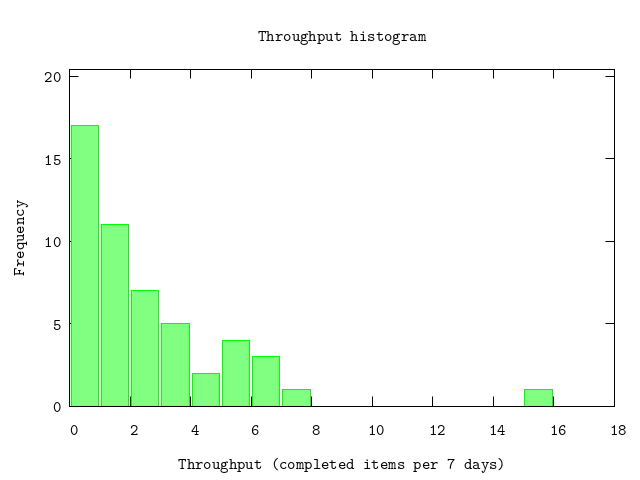

In [21]:
P.histogram(data,
    plottitle: "Throughput histogram",
    xlabel: "Throughput (completed items per #{units} days)",
    ylabel: "Frequency",
    xrange: '[0:#{maxdays*1.2}]',
    yrange: '[0:#{max_frequency*1.2}]',
    bin: binsize)
:"this is an inline image"

The chart may show a couple of things. Two important properties are (a) whether the data is multi modal or not and (b) whether it shows indications of a fat-tail.

Multi modal is recognized by more than 1 mode. Multi-modal data mostly is a result from the presence of multiple work item types. This will be analyzed below in more detail.

Fat-tailed data. This is also known as extremistan. Linear regression to the mean is not possible. The presence of data far to the right of the chart away from the mean, is a very strong indication that the data is extremistan.

### Thin- or fat-tailed data?

An important property of the data is to determine whether it is fat-tailed or not. With thin-tailed data forecasting is less uncertain, and is preferred.

A differentiator between mediocristan and extremistan data is to test the data sample for subexponentiality. Taleb [8] mentions 2 tests for this.

In [22]:
# Test 1:
# A value close to zero, say within 0.1, indicates it is extremistan (fat-tailed, subexponential)
test1 = data |> S.subexponential_stat(:max) < 0.1

true

In [23]:
# Test 2:
# A value close to zero, say within 0.1, indicates it is extremistan (fat-tailed, subexponential)
test2 = data |> S.subexponential_stat(:sum) < 0.1

true

In [24]:
# Thin or fat tailed distribution?
# See KMM.plus for an explanation of the numbers
check1 = tail/median < 5.6
check2 = if mode>0, do: tail/mode < 16, else: false

case {check1,check2} do
  {true,true} -> IO.puts "Data is thin tailed!"
  {false,false} -> IO.puts "Data is fat tailed!"
  _else -> IO.puts "Inclusive whether data is thin or fat tailed, check for multi-modal data (see below)"
end
:"do not show this result in output"

Data is fat tailed!


## Empirical distribution

As a first step we convert the throughput data to a histogram. To this end we group the data in bins of size 1 starting at 0 and determine the cumulative distribution function (CDF). Since it is directly calculated from the observed data, we will call this the empirical cumulative distribution function (ECDF). This is the function that we will use to find a suitable probability distribution that describes the data.

An important property of a CDF (and therefor also for the ECDF) is that the value always is between 0 and 1.

In [25]:
hdata = S.to_bins data, {binsize,0}
hdata |> U.as_table({"bin index","value","low","high"})
:"do not show this result in output"

bin index|value             |low               |high               
---------|------------------|------------------|-------------------
1        |0.3333333333333333|0.2619590316047003|0.41205985002195966
2        |0.5490196078431373|0.4693334933381733|0.6265576074897032 
3        |0.6862745098039216|0.6081128777585465|0.7562025291870149 
4        |0.7843137254901961|0.7110378681422991|0.8448186366836251 
5        |0.8235294117647058|0.7533661771437564|0.8790002461835639 
6        |0.9019607843137255|0.8409447560847112|0.9439686602963081 
7        |0.9607843137254902|0.9111357425558969|0.9866556598542698 
8        |0.9803921568627451|0.9364212632226532|0.9973690503039632 
16       |1.0               |0.9641694112344984|1.0                


The data returned contains a list of tuples each describing a bin:
* the end-point of the bin,
* the proportional number of events for this bin (the total count is normalized to one),
* the lower value of the error bound,
* the upper value of the error bound.

As can be seen the sizes of the lower and upper bounds are different in value, i.e. they are asymmetrical. The contribution or weight to the likelihood function used in fitting known distributions will de different depending on whether the observed value if larger or smaller than the predicted value. This is specified by using the option `:linear` (see below). See [3] for details.

A consequence that the values of a CDF are between 0 and 1, is that the low and high bounds must be between 0 and 1. From this it follows that the error bounds are asymmetrical in nature. When finding a suitable distribution we need to take this into account.

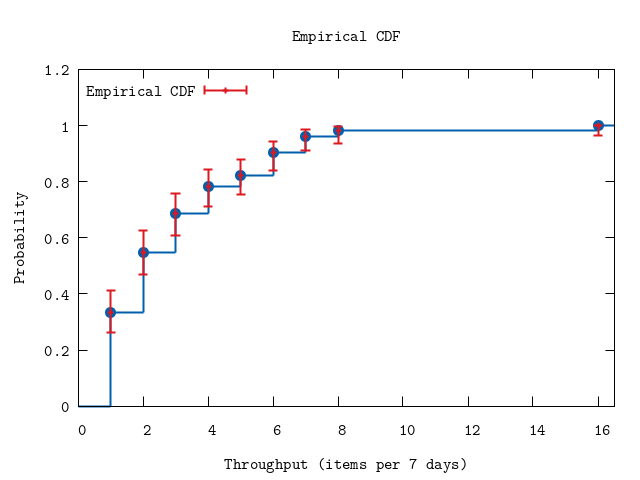

In [26]:
P.ecdf(hdata,
    plottitle: "Empirical CDF",
    xlabel: "Throughput (items per #{units} days)",
    ylabel: "Probability",
    xrange: '[0:#{maxdays*1.1}]',
    bin: binsize)
:"this is an inline image"

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf<br>
[5] _Understanding lead time_, https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiIi9Py19zwAhW2DWMBHdKYDz0QFjALegQIHRAD&url=https%3A%2F%2Fmauvisoft.com%2Fkmm-understanding-lead-time%2F&usg=AOvVaw1iDIcri4tDi3vxo1W6yJp-<br>
[6] _Kanban Maturity Model_, .....<br>
[7] _KMM: A Map To Organizational Agility, Resilience & Reinvention_, http://kmm.plus<br>
[8] _Statistical consequences of fat tails_, Nassim Taleb